In [1]:
import numpy as np
from matplotlib import pyplot as plt
import reciprocalspaceship as rs
import gemmi as gm
import os
import pandas as pd
import glob
import gemmi
import re
import seaborn as sns

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 18,
    #"font.family" : "sans-serif",
    #"font.sans-serif" : ["Nimbus Sans"],
}
plt.rcParams.update(new_rc_params)

cbrewer1="#1b9e77"
cbrewer2="#d95f02"
cbrewer3="#7570b3"

In [2]:
file_pattern = './20221007_unscaled_unmerged/UCSF-P*/out_ohp.mtz'
files = glob.glob(file_pattern)
dataset_names = []
files.sort()
for name in files:
    dataset_names.append(name[-17:-12])

## preprocessing

In [28]:
def write_SIGF(FC_in_mtz):
    FC_in_mtz["SIGF"] = 0.01 
    FC_in_mtz["SIGF"] = FC_in_mtz["SIGF"].astype("Stddev")
    return FC_in_mtz

In [ ]:
for UCSF_name in dataset_names:
    print(UCSF_name)
    FC_off=rs.read_mtz("20221007_unscaled_unmerged/reference/7kqo.pdb.mtz")
    
    write_SIGF(FC_off).write_mtz("20221007_unscaled_unmerged/reference/7kqo.pdb.mtz")
    
    FC_on = rs.read_mtz(f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/UCSF-{UCSF_name}-pandda-model.pdb.mtz")
    write_SIGF(FC_on).write_mtz(f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/UCSF-{UCSF_name}-pandda-model.pdb.mtz")
    
    
    cmd = f"""source /n/hekstra_lab_tier0/Lab/garden/ccp4/ccp4-7.1/bin/ccp4.setup-sh;
    rs.scaleit -r 20221007_unscaled_unmerged/reference/7kqo.pdb.mtz FMODEL SIGF \
    -i 20221007_unscaled_unmerged/UCSF-{UCSF_name}/UCSF-{UCSF_name}-pandda-model.pdb.mtz FMODEL SIGF \
    -o 20221007_unscaled_unmerged/UCSF-{UCSF_name}/{UCSF_name}_scaledto_apo.mtz"""
    
    os.system(cmd)
    
    a = rs.read_mtz(f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/{UCSF_name}_scaledto_apo.mtz")
    a["PHIFMODEL"] = FC_on["PHIFMODEL"]
    a["FMODEL"]  = a["FPH1"]
    a.write_mtz(f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/{UCSF_name}_scaledto_apo.mtz")

P0115
<B><FONT COLOR="#FF0000"><!--SUMMARY_BEGIN-->
<html> <!-- CCP4 HTML LOGFILE -->
<hr>
<!--SUMMARY_END--></FONT></B>

<a name="scaleitscaleit"><h2>SCALEIT</h2></a>
<B><FONT COLOR="#FF0000"><!--SUMMARY_BEGIN-->
<pre>
 
 ###############################################################
 ###############################################################
 ###############################################################
 ### CCP4 7.1.008: SCALEIT          version 7.1.008 :         ##
 ###############################################################
 User: unknown  Run date:  5/ 8/2025 Run time: 17:32:07 


 Please reference: Collaborative Computational Project, Number 4. 2011.
 "Overview of the CCP4 suite and current developments". Acta Cryst. D67, 235-242.
 as well as any specific reference in the program write-up.

<!--SUMMARY_END--></FONT></B>
<B><FONT COLOR="#FF0000"><!--SUMMARY_BEGIN-->

<a name="tocSCALEIT"><h2>Contents</h2></a>
<ul>
<li><a href="#commandSCALEIT">Command Input</a>
<li><a

## function definitions

In [7]:
def z_map_CC(UCSF_name, radius=0.6):
    map_DF = gemmi.read_ccp4_map(f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/UCSF-{UCSF_name}-z_map.native_T.ccp4")
    gridsize=(180,180,80)
    FC_off=rs.read_mtz("20221007_unscaled_unmerged/reference/7kqo.pdb.mtz")
    #FC_off = rs.read_mtz("20221007_unscaled_unmerged/reference/apo_edit.pdb.mtz")
    #in_FC = f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/UCSF-{UCSF_name}-pandda-model.pdb.mtz"
    in_FC=f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/{UCSF_name}_scaledto_apo.mtz"
    FC_on =rs.read_mtz(in_FC)
    
    ds_FcFc = FC_off.copy()
    ds_FcFc["sf_FC_off"] = FC_off.to_structurefactor("FMODEL", "PHIFMODEL")
    rg_Fc_off = ds_FcFc.to_reciprocal_grid("sf_FC_off", grid_size=gridsize)
    map_Fc_off = np.real(np.fft.fftn(rg_Fc_off))
    
    FC_on["sf_FC_on"]  = FC_on.to_structurefactor( "FMODEL", "PHIFMODEL")
    rg_Fc_on = FC_on.to_reciprocal_grid("sf_FC_on", grid_size=gridsize)
    map_Fc_on = np.real(np.fft.fftn(rg_Fc_on))

    model = gm.read_structure(f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/UCSF-{UCSF_name}-pandda-model.pdb")
    
    gm_map_DF = map_DF.grid # gm.FloatGrid(map_DF.astype(np.float32))
    gm_map_DF.set_unit_cell(model.cell)
    gm_map_DF.spacegroup=gm.SpaceGroup('P43')

    gr = gm_map_DF.clone()
    gr.fill(0)
    
    HC4=model[0][1][0]
    ligand_points=[]
    ops = gr.spacegroup.operations()
    for atom in HC4:
        for op in ops:
            ligand_mapped=op.apply_to_xyz(model.cell.fractionalize(atom.pos).tolist())
        #     print(f"xyz: {HC4_mapped[0]:.3}, {HC4_mapped[1]:.3}, {HC4_mapped[2]:.3} ") 
        
            tmp = ligand_mapped-np.floor(np.array(ligand_mapped))
            ligand_mapped = gm.Fractional(*tmp)
            ligand_points.append(ligand_mapped)
    
    for pos in ligand_points:
        gr.set_points_around(model.cell.orthogonalize(pos), radius=radius, value=1)
    print(f"Fraction of all voxels within ROI: {100*gr.sum()/np.prod(np.array(gr).shape):.4}%")
    
    DFO=np.array(gm_map_DF).flatten()
    keep=(np.array(gr)==1).flatten()    
    DFC=(map_Fc_on-map_Fc_off).flatten()

    return [np.corrcoef(DFO, DFC)[0][1], 
    np.corrcoef(DFO[keep], DFC[keep])[0][1],
    np.corrcoef(DFO[~keep],DFC[~keep])[0][1],np.abs(DFO[keep]).mean()/DFO.std()]

In [8]:
def diffmap_CC(dataset_name, UCSF_name, radius=0.6):
    ds_diff=rs.read_mtz(dataset_name)
    print(UCSF_name)
    try:
        ds_diff["DF"]=ds_diff["DF"]
    except:
        print("Field not found")
    
    try:
        tmp=(ds_diff.dtypes=="Phase")
        tmp=tmp.index[tmp==True].to_list()[0]
        ds_diff["Phi"]=ds_diff[tmp]
    except:
        print("No phase column found")
    
    
    ds_diff.dropna(inplace=True)
    ds_diff["sf_DF"]  = ds_diff.to_structurefactor("DF",  "Phi")
    # ds_diff.head()
    
    gridsize=(128,128,64)
    rg_DF  = ds_diff.to_reciprocal_grid("sf_DF",  grid_size=gridsize)
    map_DF = np.real(np.fft.fftn(rg_DF))

    FC_off=rs.read_mtz("20221007_unscaled_unmerged/reference/7kqo.pdb.mtz")
    #FC_off = rs.read_mtz("20221007_unscaled_unmerged/reference/apo_edit.pdb.mtz")
    #in_FC = f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/UCSF-{UCSF_name}-pandda-model.pdb.mtz"
    in_FC=f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/{UCSF_name}_scaledto_apo.mtz"
    FC_on =rs.read_mtz(in_FC)
    
    ds_FcFc = FC_off.copy()
    ds_FcFc["sf_FC_off"] = FC_off.to_structurefactor("FMODEL", "PHIFMODEL")
    rg_Fc_off = ds_FcFc.to_reciprocal_grid("sf_FC_off", grid_size=gridsize)
    map_Fc_off = np.real(np.fft.fftn(rg_Fc_off))
    
    FC_on["sf_FC_on"]  = FC_on.to_structurefactor( "FMODEL", "PHIFMODEL")
    rg_Fc_on = FC_on.to_reciprocal_grid("sf_FC_on", grid_size=gridsize)
    map_Fc_on = np.real(np.fft.fftn(rg_Fc_on))

    model = gm.read_structure(f"20221007_unscaled_unmerged/UCSF-{UCSF_name}/UCSF-{UCSF_name}-pandda-model.pdb")
    
    gm_map_DF = gm.FloatGrid(map_DF.astype(np.float32))
    gm_map_DF.set_unit_cell(model.cell)
    gm_map_DF.spacegroup=gm.SpaceGroup('P43')

    gr = gm_map_DF.clone()
    gr.fill(0)
    
    HC4=model[0][1][0]
    ligand_points=[]
    ops = gr.spacegroup.operations()
    for atom in HC4:
        for op in ops:
            ligand_mapped=op.apply_to_xyz(model.cell.fractionalize(atom.pos).tolist())
        #     print(f"xyz: {HC4_mapped[0]:.3}, {HC4_mapped[1]:.3}, {HC4_mapped[2]:.3} ") 
        
            tmp = ligand_mapped-np.floor(np.array(ligand_mapped))
            ligand_mapped = gm.Fractional(*tmp)
            ligand_points.append(ligand_mapped)

    for pos in ligand_points:
        gr.set_points_around(model.cell.orthogonalize(pos), radius=radius, value=1)
    print(f"Fraction of all voxels within ROI: {100*gr.sum()/np.prod(np.array(gr).shape):.4}%")
    
    DFO=map_DF.flatten()
    keep=(np.array(gr)==1).flatten()    
    DFC=(map_Fc_on-map_Fc_off).flatten()

    return [np.corrcoef(DFO, DFC)[0][1], 
    np.corrcoef(DFO[keep], DFC[keep])[0][1],
    np.corrcoef(DFO[~keep],DFC[~keep])[0][1],np.abs(DFO[keep]).mean()/DFO.std()]

In [12]:
for radius in [0.6,6]:
    all_rscc = []
    for name,ind in zip(dataset_names, range(2,18)):
        out_z = z_map_CC(name,radius=radius)
    
        all_rscc.append(pd.DataFrame({"dataset":[name], "ind":"PanDDA", 
                                          "DF_CC_overall":out_z[0],
                                          "DF_CC_keep":out_z[1],
                                          "DF_CC_notkeep":out_z[2],
                                        "DF_avg_voxel":out_z[3]}))
        
        a = glob.glob(f"careless_runs/*/wdm_{ind}.mtz")
        for dataset in a: 
            print(dataset)
            out = diffmap_CC(dataset, name,radius=radius)
            all_rscc.append(pd.DataFrame({"dataset":[name], "ind":re.split('/|_', dataset)[-3], 
                                          "DF_CC_overall":out[0],
                                          "DF_CC_keep":out[1],
                                          "DF_CC_notkeep":out[2],
                                         "DF_avg_voxel":out[3]}))
    
    all_rscc=pd.concat(all_rscc)

    all_rscc["ind"] = all_rscc["ind"].apply(lambda a: 0 if a=="PanDDA" else a)
    
    all_rscc["ind"] = all_rscc["ind"].astype("int")
    all_rscc.sort_values(by=["dataset","ind"])
    all_rscc.to_csv(f"rscc_pandda-7kqo-with_avgvoxel_r{radius}_scaledtoapo.csv")
    #radius="0,6"
    all_rscc = pd.read_csv(f"rscc_pandda-7kqo-with_avgvoxel_r{radius}_scaledtoapo.csv")
    type_="DF_CC_keep"
    table = all_rscc[["ind","dataset",type_]].pivot_table(index='dataset', columns='ind', values=type_)
    max_CC_pandda = table[0]
    table = table.drop(columns=[0])
    max_height_indices = table.idxmax(axis=1)
    #table.fillna(5, inplace=True) #diffmap peak heights are cut at 5sigma, so any NaNs are filled with value of 5. 
    univariate = table[2]
    max_table = table.max(axis="columns").to_numpy()
    table = table.div(max_table, axis='rows')
    
    barplot_df = pd.DataFrame({"dataset name":table.index,"univariate":univariate,"multivariate":max_table,"PanDDA":max_CC_pandda})
    barplot_df = pd.melt(barplot_df, id_vars="dataset name",var_name="analysis type",value_name="height")
    ax = sns.barplot(x='dataset name', y='height', hue='analysis type', data=barplot_df, palette="Dark2")
    
    ticks = ax.get_xticklabels()
    for ind,tick in enumerate(ticks):
        tick.set_rotation(45)
        tick.set_ha("right")
    plt.ylim([-0.15,0.83])
    plt.ylabel("rscc near ligand (σ)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f"pandda_comparison_{type_}_{radius}.svg",bbox_inches="tight")
    plt.clf()

Fraction of all voxels within ROI: 0.05741%
careless_runs/merge_20379811_3528_mono_mc1_10k_grid_9/wdm_2.mtz
P0115
Fraction of all voxels within ROI: 0.05951%
careless_runs/merge_20379920_12673_mono_mc1_10k_grid_11/wdm_2.mtz
P0115
Fraction of all voxels within ROI: 0.05951%
careless_runs/merge_20379915_20830_mono_mc1_10k_grid_6/wdm_2.mtz
P0115
Fraction of all voxels within ROI: 0.05951%
careless_runs/merge_20379917_9008_mono_mc1_10k_grid_7/wdm_2.mtz
P0115
Fraction of all voxels within ROI: 0.05951%
careless_runs/merge_20379919_22723_mono_mc1_10k_grid_10/wdm_2.mtz
P0115
Fraction of all voxels within ROI: 0.05951%
careless_runs/merge_20379913_17439_mono_mc1_10k_grid_4/wdm_2.mtz
P0115
Fraction of all voxels within ROI: 0.05951%
careless_runs/merge_20379914_10904_mono_mc1_10k_grid_5/wdm_2.mtz
P0115
Fraction of all voxels within ROI: 0.05951%
careless_runs/merge_28790352_16366_mono_mc1_10k_grid_8/wdm_2.mtz
P0115
Fraction of all voxels within ROI: 0.05951%
careless_runs/merge_20379918_5300_mo

RuntimeError: Failed to open careless_runs/merge_28790352_16366_mono_mc1_10k_grid_8/wdm_14.mtz: No such file or directory: careless_runs/merge_28790352_16366_mono_mc1_10k_grid_8/wdm_14.mtz

In [ ]:
all_rscc["ind"] = all_rscc["ind"].apply(lambda a: 0 if a=="PanDDA" else a)

In [ ]:

all_rscc["ind"] = all_rscc["ind"].astype("int")
all_rscc.sort_values(by=["dataset","ind"])

In [ ]:
all_rscc.to_csv(f"rscc_pandda-7kqo-with_avgvoxel_r{radius}_scaledtoapo.csv")
#radius="0,6"
#all_rscc = pd.read_csv(f"rscc_pandda-7kqo-with_avgvoxel_r{radius}.csv")

In [ ]:
type_="DF_CC_keep"
table = all_rscc[["ind","dataset",type_]].pivot_table(index='dataset', columns='ind', values=type_)
max_CC_pandda = table[0]
table = table.drop(columns=[0])
max_height_indices = table.idxmax(axis=1)
#table.fillna(5, inplace=True) #diffmap peak heights are cut at 5sigma, so any NaNs are filled with value of 5. 
univariate = table[2]
max_table = table.max(axis="columns").to_numpy()
table = table.div(max_table, axis='rows')

barplot_df = pd.DataFrame({"dataset name":table.index,"univariate":univariate,"multivariate":max_table,"PanDDA":max_CC_pandda})
barplot_df = pd.melt(barplot_df, id_vars="dataset name",var_name="analysis type",value_name="height")
ax = sns.barplot(x='dataset name', y='height', hue='analysis type', data=barplot_df, palette="Dark2")

ticks = ax.get_xticklabels()
for ind,tick in enumerate(ticks):
    tick.set_rotation(45)
    tick.set_ha("right")
plt.ylim([-0.15,0.81])
plt.ylabel("rscc near ligand (σ)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f"pandda_comparison_{type_}_{radius}.svg",bbox_inches="tight")

In [95]:
max_height_indices

dataset
P0115    11
P0116     4
P0123     7
P0124     5
P0131     4
P0132     4
P0137    10
P0138     6
P0139    11
P0142     6
P0148    11
P0159    11
P0161    11
P0163    11
P0178    11
P0179    11
dtype: int64

In [96]:
result = pd.DataFrame()
result["log_dw"] = np.log10(1/2**(max_height_indices-2))

In [97]:
result["1-BDC"] = [0.14, 0.1, 0.13, 0.1, 0.17, 0.17, 
                   0.18, 0.13, 0.2, 0.07, 0.19, 0.36, 
                   0.27, 0.14, 0.16, 0.33]

In [98]:
result

,log_dw,1-BDC
dataset,,
P0115,-2.70927,0.14
P0116,-0.60206,0.10
P0123,-1.50515,0.13
P0124,-0.90309,0.10
P0131,-0.60206,0.17
P0132,-0.60206,0.17
P0137,-2.40824,0.18
P0138,-1.20412,0.13
P0139,-2.70927,0.20


          log_dw     1-BDC
log_dw  1.000000 -0.563291
1-BDC  -0.563291  1.000000


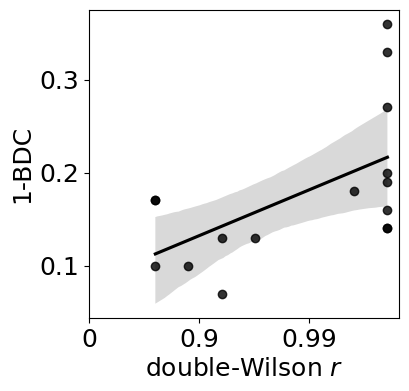

In [99]:
fig, ax = plt.subplots(figsize=[4,4])
#result["log_dw"] = np.log10(1-result["rDW"])
sns.regplot(data=result, x="log_dw", y="1-BDC",ax=ax, color="k")
plt.ylabel(r"1-BDC")
plt.xlabel(r"double-Wilson $r$")
print(result[["log_dw","1-BDC"]].corr())
plt.xticks(ticks=[-2,-1,0],labels=["0.99","0.9","0"])
plt.gca().invert_xaxis()
plt.savefig(f"bdc_rdw_corr_peaksum_r{radius}.svg", bbox_inches="tight")

In [102]:
from scipy.stats import pearsonr
pearsonr(result["log_dw"],result["1-BDC"],alternative="two-sided")

PearsonRResult(statistic=-0.5632906958191991, pvalue=0.023080475844430973)